#LAB 3  - REDES GANs
Nombre: Ariel Rodrigo Colque Garcia
* *Dataset*: STL10.- Es un conjunto de datos de imágenes de 10 clases, que consta de un total de 13,000 imágenes en color de 96x96 píxeles. Cada imagen está etiquetada con una de las 10 clases posibles: 

        1. avión
        2. automóvil
        3. pájaro
        4. gato
        5. ciervo
        6. perro
        7. rana
        8. caballo
        9. barco
        10. camión



El conjunto de datos STL10 se divide en 2 partes: entrenamiento y prueba. La parte de entrenamiento consta de 5,000 imágenes etiquetadas y la parte de prueba consta de 8,000 imágenes etiquetada

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

# Descargar el conjunto de datos y aplicar transformaciones
# stl10_dataset = datasets.STL10(root='./data', split='train', download=True)

# Carga de los Datos
Debido a que el conjunto de datos STL10 consta de solo 5,000 imágenes para entrenamiento, se ha tomado la decisión de combinar los datos de entrenamiento y prueba en un solo conjunto de datos. Al hacer esto, hemos aumentado el tamaño del conjunto de datos a 13,000 imágenes, lo que nos permitirá entrenar nuestro modelo con más datos y mejorar potencialmente su capacidad de generalización.

In [52]:
# Concatenacion de los datos train y test
train_dataset = datasets.STL10(root="./data", split='train', download=True)
test_dataset = datasets.STL10(root="./data", split='test', download=True)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

Files already downloaded and verified
Files already downloaded and verified


In [53]:
# Creamos sus clases
classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Clase Dataset

In [55]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        # normaliza las imágenes y las convierte en torch tensor
        self.imgs = torch.tensor([np.array(i[0]).transpose((2, 0, 1)) / 255. for i in trainset], dtype=torch.float, device=device)

        # convierte las etiquetas en torch tensor
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

    def __len__(self):
        # toma el tamaño de las imágenes
        return len(self.imgs)

    def __getitem__(self, ix):
        # devuelve la imagen y su etiqueta correspondiente
        return self.imgs[ix], self.labels[ix]


# creamos el dataset
train = Dataset(full_dataset)
len(train)

13000

In [56]:
# prueba
img, label = train[10]
# normalizados
img.shape, img.dtype, img.max(), img.min()

(torch.Size([3, 96, 96]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

Crear Dataloader

In [57]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=0)
imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 3, 96, 96]), torch.Size([32]))

# Visualizacion de las imagenes.

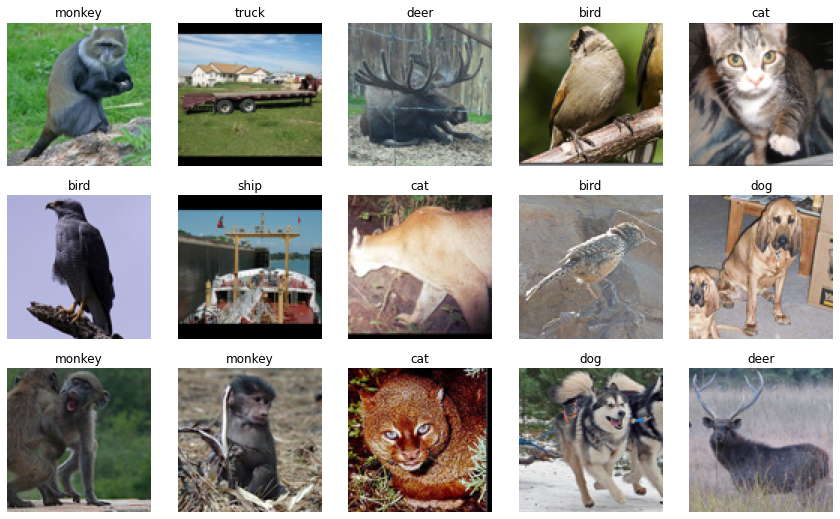

In [58]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(3, 96, 96).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()


# GENERADOR

In [59]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 6*6*512),
            nn.BatchNorm1d(6*6*512),
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 512, 6, 6)
        x = self.main(x)
        x = x.view(x.size(0), 3, 96, 96)
        return x


In [60]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 3, 96, 96])

#Discriminador

In [61]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(128 * 24 * 24, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x


In [62]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 3, 96, 96))
output.shape

torch.Size([64, 1])

# ENTRENAMIENTO

In [84]:
def train_gan(generator, discriminator, dataloader, num_epochs=30):
    # función de pérdida binaria cruzada
    criterion = nn.BCELoss()

    # optimizadores para el generador y el discriminador
    optimizer_g = torch.optim.Adam(generator.parameters(), lr= 0.0001)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr= 0.0001)

    # etiquetas verdaderas y falsas para el discriminador
    real_label = 1
    fake_label = 0

    # lista para almacenar la pérdida del generador y el discriminador
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # tamaño del lote
            batch_size = imgs.size(0)

            # etiquetas verdaderas y falsas para el discriminador
            real_labels = torch.full((batch_size,), real_label, device=device).float()
            fake_labels = torch.full((batch_size,), fake_label, device=device).float()

            # entrenamiento del discriminador con imágenes reales
            discriminator.zero_grad()
            real_output = discriminator(imgs.to(device)).view(-1)
            d_loss_real = criterion(real_output, real_labels)

            # entrenamiento del discriminador con imágenes falsas generadas por el generador
            noise = torch.randn(batch_size, 100, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs.detach()).view(-1)
            d_loss_fake = criterion(fake_output, fake_labels)

            # actualización de los pesos del discriminador
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # entrenamiento del generador para engañar al discriminador
            generator.zero_grad()
            fake_output = discriminator(fake_imgs).view(-1)
            g_loss = criterion(fake_output, real_labels)

            # actualización de los pesos del generador
            g_loss.backward()
            optimizer_g.step()

        # almacenamiento de la pérdida del generador y el discriminador en cada época
        hist['g_loss'].append(g_loss.item())    
        hist['d_loss'].append(d_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")

    return hist


In [85]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

hist = train_gan(generator, discriminator, dataloader)

Epoch [1/30], Discriminator Loss: 0.0016, Generator Loss: 7.8794
Epoch [2/30], Discriminator Loss: 0.0014, Generator Loss: 7.4325
Epoch [3/30], Discriminator Loss: 0.0087, Generator Loss: 9.7740
Epoch [4/30], Discriminator Loss: 0.0035, Generator Loss: 6.9962
Epoch [5/30], Discriminator Loss: 0.0340, Generator Loss: 8.4471
Epoch [6/30], Discriminator Loss: 0.0156, Generator Loss: 6.3408
Epoch [7/30], Discriminator Loss: 0.0096, Generator Loss: 7.8997
Epoch [8/30], Discriminator Loss: 0.1162, Generator Loss: 6.3172
Epoch [9/30], Discriminator Loss: 0.2689, Generator Loss: 5.1411
Epoch [10/30], Discriminator Loss: 0.0342, Generator Loss: 6.4692
Epoch [11/30], Discriminator Loss: 0.5382, Generator Loss: 7.0063
Epoch [12/30], Discriminator Loss: 0.0138, Generator Loss: 7.7600
Epoch [13/30], Discriminator Loss: 1.2031, Generator Loss: 6.9435
Epoch [14/30], Discriminator Loss: 0.6384, Generator Loss: 3.8836
Epoch [15/30], Discriminator Loss: 0.3109, Generator Loss: 3.5438
Epoch [16/30], Disc

# GRAFICO DE PERDIDAS (loss)

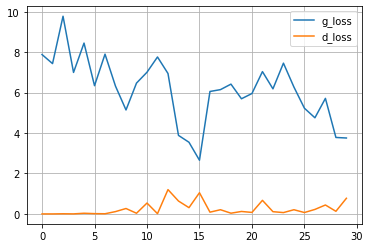

In [86]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

# GENERACION DE IMAGENES

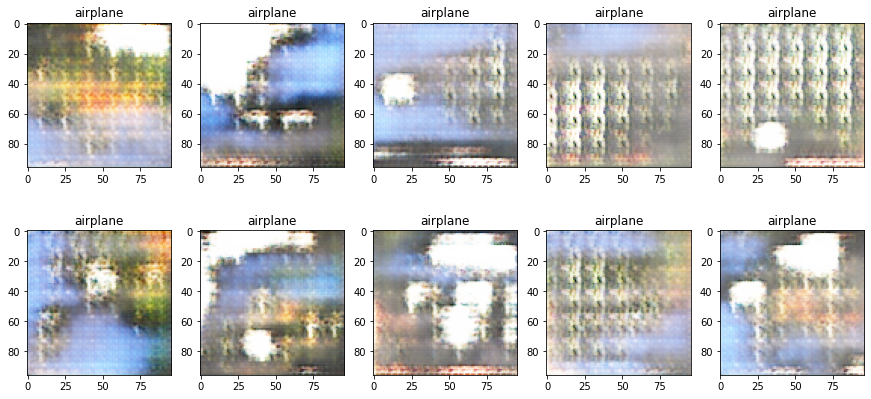

In [87]:
# generamos las imagenes
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size), device=device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,7))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].permute(1, 2, 0).cpu()
      img = (img - img.min()) / (img.max() - img.min())  # normalizar en [0, 1]
      class_idx = torch.argmax(discriminator(generated_images[i].unsqueeze(0).to(device)))
      _ax.set_title(classes[class_idx])
      _ax.imshow(img.permute(2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
      i+=1
  plt.show()
